In [1]:
import itertools as it
import warnings

import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    from skopt import gp_minimize
    from skopt.space import Real, Integer, Categorical
    from skopt.utils import use_named_args
import seaborn as sns

sns.set()

In [2]:
def make_regression(func, n_elements, noise=0.0, random_state=None):
    rng = np.random.RandomState(random_state)
    x = rng.uniform(5.0, size=n_elements)
    n = rng.normal(scale=noise, size=n_elements)
    y = func(x) + n
    return x.reshape(-1, 1), y

def plot_regression_line(clf, xb, yb, n=100):
    xx = np.linspace(*xb, n).reshape(-1, 1)
    yy = clf.predict(xx)
    plt.plot(xx, yy, color='red', linewidth=20, alpha=0.3)

In [3]:
X, y = make_regression(lambda x: x**2 + 2*x, 1000, random_state=0, noise=5.0)
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=0, test_size=0.2)
train_X, dev_X, train_y, dev_y = train_test_split(train_X, train_y, random_state=0, test_size=0.15)

In [4]:
space = [
    Categorical(['poly', 'rbf'], name='kernel'),
    Integer(2, 4, name='degree'),
    Categorical(['auto', 'scale'], name='gamma'),
    Real(0.01, 5.0, name='C'),
    Real(0.01, 5.0, name='epsilon')
]

@use_named_args(space)
def objective(**params):
    clf = SVR(**params)
    clf.fit(train_X, train_y)
    pred = clf.predict(dev_X)
    return mean_squared_error(dev_y, pred)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    res = gp_minimize(objective, space, n_calls=50, n_jobs=-1, random_state=0)

In [8]:
res.fun

20.875167569955813

In [5]:
best_params = dict(zip([s.name for s in space], res.x))
best_params

{'kernel': 'poly',
 'degree': 3,
 'gamma': 'scale',
 'C': 0.01,
 'epsilon': 1.0213753342666452}

In [6]:
best_clf = SVR(**best_params)
best_clf.fit(train_X, train_y)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=3, epsilon=1.0213753342666452,
    gamma='scale', kernel='poly', max_iter=-1, shrinking=True, tol=0.001,
    verbose=False)

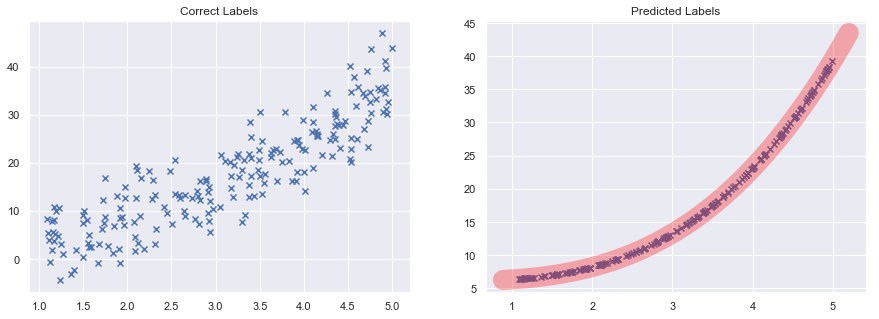

In [7]:
plt.figure(figsize=(15, 5))
pred = best_clf.predict(test_X)
plt.subplot(1, 2, 1)
plt.title('Correct Labels')
plt.scatter(test_X.ravel(), test_y, marker='x')
plt.subplot(1, 2, 2)
plt.title('Predicted Labels')
plt.scatter(test_X.ravel(), pred, marker='x')
plot_regression_line(best_clf, plt.xlim(), plt.ylim())
plt.show()